# Census Files Processing

## Work Process


### Description
This notebook handles the census data files: 
1. loading the files 
2. Data processing: 
    1. handling data types and missing values 
    2. initial dimensionality reduction based on context and data-quality 
    3. further dimensionality reduction based on features correlation 
3. initial EDA: discriptive statistics and visualizations. 

The analysis in this notebook is done for data of the Boston PD only. 
The groundwork is layed for pipelining the process for other departments, however several factors are unique and need attention when scaling to additional departments (such as determining missing value methods). 

### Files Structure
Demographic statistic parameters are provided from the ACS department of the USA, for each city for which police departments reports exist.
The ACS data is divided to several demographic and socio-economic categories, standardized for categories and structure. 
There are 7 demographic categories, split by age, gender, race and additional category relevant factors.  
1. education-attainment
2. education-attainment-over-25
3. employment
4. income
5. owner-occupied-housing
6. poverty
7. race-sex-age 

The columns are conformly coded, and a metadata file  with the column descriptions is available for each category, including the statistical estimate that was used in each column. 

### Goal of this notebook:
The census files are supplementary data for the police reporting analysis. 
1. Clean the data
2. reduce dimentionality with focus of quality and relevance to the police reportings
3. visualize demo parameters by tracts for one police department, as well as the distributions of the different parameters.

** the notebook aims at clarity of code rather than reproducable pipeline



## Data loading

In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import zipfile
import warnings

from functools import reduce
from feature_engine.selection import DropCorrelatedFeatures


In [2]:
# view settings for clearer cell outputs
warnings.filterwarnings("ignore")
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

In [3]:
# globals
DATA_BASEPATH = "./data/data-science-for-good/versions/18"
CENSUS_ZIPFILES = "./data/census_zip_shapefiles"

DEPT_CITY_CODES = {
    "11-00091": {"city": "Boston", "address": "Boston, Massachusetts", "census": "25"},
    "23-00089": {
        "city": "Indianapolis",
        "address": "Indianapolis, Indiana",
        "census": "18",
    },
    "24-00013": {
        "city": "Minneapolis",
        "address": "Minneapolis, Minnesota",
        "census": "27",
    },
    "24-00098": {
        "city": "Saint Paul",
        "address": "Saint Paul, Minnesota",
        "census": "27",
    },
    "35-00016": {"city": "Orlando", "address": "Orlando, Florida", "census": "12"},
    "35-00103": {
        "city": "Charlotte Mecklenburg",
        "address": "Charlotte Mecklenburg, Florida",
        "census": "12",
    },
    "37-00027": {"city": "Austin", "address": "Austin, Texas", "census": "48"},
    "37-00049": {"city": "Dallas", "address": "Dallas, Texas", "census": "48"},
    "49-00009": {"city": "Seattle", "address": "Seattle, Washington", "census": "53"},
    "49-00033": {
        "city": "Los Angeles",
        "address": "Los Angeles, California",
        "census": "53",
    },
    "49-00035": {"city": "Oakland", "address": "Oakland, California", "census": "53"},
    "49-00081": {
        "city": "San Fransisco",
        "address": "San Fransisco, California",
        "census": "53",
    },
}

In [4]:
# unzip the downloaded zip-shape-files for the different tracts:
dept_list = [
    dir
    for dir in os.listdir(DATA_BASEPATH)
    if os.path.isdir(os.path.join(DATA_BASEPATH, dir))
]

for department in dept_list:
    name = department.lstrip("Dept_")
    target_folder = os.path.join(
        DATA_BASEPATH, department, f"{name}_ACS_data", "census_shapefiles"
    )
    code = DEPT_CITY_CODES[name]["census"]
    zip_path = os.path.join(CENSUS_ZIPFILES, f"tl_2020_{code}_tract.zip")
    if not os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path) as z:
            z.extractall(target_folder)
    else:
        print(f"unzipped-files-path for department {department} exists.")

unzipped-files-path for department Dept_49-00081 exists.
unzipped-files-path for department Dept_24-00098 exists.
unzipped-files-path for department Dept_35-00016 exists.
unzipped-files-path for department Dept_37-00027 exists.
unzipped-files-path for department Dept_49-00033 exists.
unzipped-files-path for department Dept_24-00013 exists.
unzipped-files-path for department Dept_49-00035 exists.
unzipped-files-path for department Dept_35-00103 exists.
unzipped-files-path for department Dept_23-00089 exists.
unzipped-files-path for department Dept_37-00049 exists.
unzipped-files-path for department Dept_11-00091 exists.
unzipped-files-path for department Dept_49-00009 exists.


### Deep Dive into the Boston Census Files

In [5]:
# collect all the census ann files for the department
dpt = "11-00091"
DPT_ACS_PATH = os.path.join(DATA_BASEPATH, f"Dept_{dpt}", f"{dpt}_ACS_data")

# list all the acs folders
dpt_acs_files = [file for file in os.listdir(DPT_ACS_PATH) if "ACS" in file]

dpt_dfs = {}
metadata_dfs = {}
# create a df for each csv of every category
demographics = [
    "education-attainment",
    "education-attainment-over-25",
    "employment",
    "income",
    "owner-occupied-housing",
    "poverty",
    "race-sex-age",
]
for category in demographics:
    for folder in dpt_acs_files:
        if folder.endswith(category):
            cat_folder = os.path.join(DPT_ACS_PATH, folder)

            # collect data and metadata csv
            for i in ["ann", "metadata"]:
                csv_name = [csv for csv in os.listdir(cat_folder) if i in csv][0]
                csv_path = os.path.join(cat_folder, csv_name)
                if i == "ann":
                    df = pd.read_csv(csv_path, na_values=["(X)", "-"])
                    dpt_dfs[category] = df
                if i == "metadata":
                    col_names = ["code", "description"]
                    df = pd.read_csv(csv_path, header=None, names=col_names)
                    metadata_dfs[category] = df

In [6]:
metadata_dfs["employment"].head(7)

,code,description
0,GEO.id,Id
1,GEO.id2,Id2
2,GEO.display-label,Geography
3,HC01_EST_VC01,Total; Estimate; Population 16 years and over
4,HC01_MOE_VC01,Total; Margin of Error; Population 16 years and over
5,HC02_EST_VC01,Labor Force Participation Rate; Estimate; Population 16 years and over
6,HC02_MOE_VC01,Labor Force Participation Rate; Margin of Error; Population 16 years and over


In [7]:
dpt_dfs["education-attainment"].head(5)

,GEO.id,GEO.id2,GEO.display-label,HC01_EST_VC02,HC01_MOE_VC02,HC02_EST_VC02,HC02_MOE_VC02,HC03_EST_VC02,HC03_MOE_VC02,HC04_EST_VC02,...,HC02_EST_VC85,HC02_MOE_VC85,HC03_EST_VC85,HC03_MOE_VC85,HC04_EST_VC85,HC04_MOE_VC85,HC05_EST_VC85,HC05_MOE_VC85,HC06_EST_VC85,HC06_MOE_VC85
0,Id,Id2,Geography,Total; Estimate; Population 18 to 24 years,Total; Margin of Error; Population 18 to 24 years,Percent; Estimate; Population 18 to 24 years,Percent; Margin of Error; Population 18 to 24 years,Males; Estimate; Population 18 to 24 years,Males; Margin of Error; Population 18 to 24 years,Percent Males; Estimate; Population 18 to 24 years,...,Percent; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Graduate or professional degree,Percent; Margin of Error; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Graduate or professional degree,Males; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Graduate or professional degree,Males; Margin of Error; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Graduate or professional degree,Percent Males; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Graduate or professional degree,Percent Males; Margin of Error; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Graduate or professional degree,Females; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Graduate or professional degree,Females; Margin of Error; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Graduate or professional degree,Percent Females; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Graduate or professional degree,Percent Females; Margin of Error; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Graduate or professional degree
1,1400000US25025000100,25025000100,"Census Tract 1, Suffolk County, Massachusetts",421,120,NaN,NaN,151,70,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1400000US25025000201,25025000201,"Census Tract 2.01, Suffolk County, Massachusetts",612,167,NaN,NaN,212,86,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1400000US25025000202,25025000202,"Census Tract 2.02, Suffolk County, Massachusetts",472,176,NaN,NaN,230,140,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1400000US25025000301,25025000301,"Census Tract 3.01, Suffolk County, Massachusetts",394,209,NaN,NaN,247,155,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# check that all the files have the same list of census tracts.
for df in dpt_dfs.values():
    print(df.shape)

# drop the first line for consistent dtypes
for key, df in dpt_dfs.items():
    dpt_dfs[key] = df.iloc[1:].reset_index(drop=True)

(205, 771)
(205, 53)
(205, 283)
(205, 123)
(205, 165)
(205, 369)
(205, 339)


In [9]:
dpt_dfs["education-attainment"].sample(frac=0.03)

,GEO.id,GEO.id2,GEO.display-label,HC01_EST_VC02,HC01_MOE_VC02,HC02_EST_VC02,HC02_MOE_VC02,HC03_EST_VC02,HC03_MOE_VC02,HC04_EST_VC02,...,HC02_EST_VC85,HC02_MOE_VC85,HC03_EST_VC85,HC03_MOE_VC85,HC04_EST_VC85,HC04_MOE_VC85,HC05_EST_VC85,HC05_MOE_VC85,HC06_EST_VC85,HC06_MOE_VC85
8,1400000US25025000503,25025000503,"Census Tract 5.03, Suffolk County, Massachusetts",676,184,NaN,NaN,226,83,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150,1400000US25025120500,25025120500,"Census Tract 1205, Suffolk County, Massachusetts",290,83,NaN,NaN,183,75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130,1400000US25025100900,25025100900,"Census Tract 1009, Suffolk County, Massachusetts",211,107,NaN,NaN,125,59,NaN,...,NaN,NaN,87188,45569,NaN,NaN,61793,11779,NaN,NaN
111,1400000US25025091500,25025091500,"Census Tract 915, Suffolk County, Massachusetts",684,193,NaN,NaN,329,143,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,1400000US25025010600,25025010600,"Census Tract 106, Suffolk County, Massachusetts",153,71,NaN,NaN,82,54,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112,1400000US25025091600,25025091600,"Census Tract 916, Suffolk County, Massachusetts",449,150,NaN,NaN,153,103,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Pre-Processing

### Processing data types 

In [10]:
# convert dtypes to numeric:
for key, df in dpt_dfs.items():
    converted = df.convert_dtypes(infer_objects=True, convert_integer=True)

    # list of columns to convert
    cols = converted.drop(columns=["GEO.id", "GEO.id2", "GEO.display-label"]).columns

    # convert just the relevant column
    converted[cols] = converted[cols].apply(pd.to_numeric, errors="coerce")

    # replace in the df
    dpt_dfs[key] = converted

In [11]:
# in this dept there are 204 census tracts. delete all the columns that have more than 150 missing data points
for key, df in dpt_dfs.items():

    empty_cols = []
    try:
        for col in df.columns:
            if df[col].isna().sum() > 150:
                empty_cols.append(col)
        print(
            f"{key} df: {len(empty_cols)} empty columns out of {df.shape[1]} columns were deleted"
        )
        df.drop(columns=empty_cols, inplace=True)
        dpt_dfs[key] = df
        print(f"new shape {key}:, {dpt_dfs[key].shape}")
        empty_cols = []
    except KeyError as e:
        print(key)
        print(f"error found{e}")
        raise e

education-attainment df: 218 empty columns out of 771 columns were deleted
new shape education-attainment:, (204, 553)
education-attainment-over-25 df: 0 empty columns out of 53 columns were deleted
new shape education-attainment-over-25:, (204, 53)
employment df: 8 empty columns out of 283 columns were deleted
new shape employment:, (204, 275)
income df: 33 empty columns out of 123 columns were deleted
new shape income:, (204, 90)
owner-occupied-housing df: 0 empty columns out of 165 columns were deleted
new shape owner-occupied-housing:, (204, 165)
poverty df: 42 empty columns out of 369 columns were deleted
new shape poverty:, (204, 327)
race-sex-age df: 11 empty columns out of 339 columns were deleted
new shape race-sex-age:, (204, 328)


### Handling missing values: Feature selection based on data quality


- the Census data has for every parameter an Estimate columne (either total count, percentage, or both - in two different columns)
- in places where the MOE (margin of error) is equal to the estimate - we can assume that the measurement is not so good. 
- the columns for MOE will be disregarded at this phase. 
- columns with MOE that is in the same size of the Estimate can be disregarded

In [12]:
# some columns have no missing values, but they have only zero values
for category, df in dpt_dfs.items():
    df = dpt_dfs[category]
    zero_cols = df.columns[(df == 0).all()]

    # check for columns that are with mostly zero values:
    threshold = 0.5 * df.shape[0]
    mostly_zero_cols = df.columns[(df == 0).sum() > threshold]
    # print('mostly zeroes: ', mostly_zero_cols)
    drop_list = zero_cols.tolist() + mostly_zero_cols.tolist()
    df.drop(columns=drop_list, inplace=True)
    dpt_dfs[category] = df

In [13]:
# check the quality of the data - if the MOE is larger than 30% of the estimate, for more than 50 tracts:
low_estimate_quality_per_category = {}

for category, df in dpt_dfs.items():

    # first, fillna for the calculation:
    df_fill = df[df.columns[3:]]
    try:
        df_fill.fillna(df_fill.median(), inplace=True)
    except TypeError:
        df_fill.fillna(df_fill.median().astype("Int64"), inplace=True)
    df[df.columns[3:]] = df_fill

    # see which columns have low quality data:
    low_quality_columns = []
    for col in df.columns:
        if "EST" in col:
            moe_col = col.replace("EST", "MOE")

            if moe_col in df.columns:

                # check how large is the MOE proportional to the estimate:
                ratio_moe = df[moe_col] / df[col]

                high_ratio_moe_count = sum(ratio_moe > 0.5)

                if high_ratio_moe_count > 100:
                    low_quality_columns.append(col)

    low_estimate_quality_per_category[category] = low_quality_columns

    print(category)
    print(f'number of "EST" columns in df: {int(df.shape[1] /2)} ')
    print(f"cols with low quality: {len(low_quality_columns)}\n")
    low_quality_columns = []

education-attainment
number of "EST" columns in df: 266 
cols with low quality: 132

education-attainment-over-25
number of "EST" columns in df: 23 
cols with low quality: 0

employment
number of "EST" columns in df: 134 
cols with low quality: 47

income
number of "EST" columns in df: 44 
cols with low quality: 9

owner-occupied-housing
number of "EST" columns in df: 79 
cols with low quality: 42

poverty
number of "EST" columns in df: 159 
cols with low quality: 91

race-sex-age
number of "EST" columns in df: 144 
cols with low quality: 0



In [14]:
# remove MOE columns: MOE is a quality measurement, and does not contribute to the case
# rage sex age file is coded differently, so that the MOE does not appear in the code, but in the description of the columns in the metadata file

for category, df in dpt_dfs.items():
    print(category)
    print(df.shape)
    columns_to_drop = [col for col in df.columns if "MOE" in col]
    df.drop(columns=columns_to_drop, inplace=True)

    if category == "race-sex-age":

        descriptions_rage_sex_age = metadata_dfs[category].loc[metadata_dfs[category]["code"].isin(df.columns)]
        moe_text = "Margin of Error"
        moe_rage_sex_age = descriptions_rage_sex_age["code"].loc[descriptions_rage_sex_age["description"].str.contains(moe_text)]
        moe_rage_sex_age
        df.drop(columns=moe_rage_sex_age, inplace=True)

    if category == "education-attainment-over-25" or category:

        descriptions_edu_over_25 = metadata_dfs[category].loc[metadata_dfs[category]["code"].isin(df.columns)]
        moe_text = "Margin of Error"
        moe_edu_over_25 = descriptions_edu_over_25["code"].loc[descriptions_edu_over_25["description"].str.contains(moe_text)]
        
        df.drop(columns=moe_edu_over_25, inplace=True)

    dpt_dfs[category] = df
    print(f"{dpt_dfs[category].shape} after dropping")

education-attainment
(204, 533)
(204, 258) after dropping
education-attainment-over-25
(204, 47)
(204, 22) after dropping
employment
(204, 268)
(204, 132) after dropping
income
(204, 88)
(204, 46) after dropping
owner-occupied-housing
(204, 158)
(204, 77) after dropping
poverty
(204, 318)
(204, 156) after dropping
race-sex-age
(204, 289)
(204, 130) after dropping


In [15]:
# check which columns include
# hawaiian or Native American, Some other race or Two races columns
# as they do not appear in the police reports:

hawaii_indian_cols_to_delete = {}

for category, cols_to_check in low_estimate_quality_per_category.items():

    if category in metadata_dfs.keys():
        hawaii_Indian_related_cols = []

        desc = metadata_dfs[category]

        for col_code in cols_to_check:

            description = desc["description"].loc[desc["code"] == col_code].values[0]
            if description:
                substrings = [
                    "American Indian",
                    "Hawaiian",
                    "Two or more races",
                    "Some other race",
                ]

                contains_substring = any(map(description.__contains__, substrings))

                if contains_substring:
                    hawaii_Indian_related_cols.append(col_code)

        hawaii_indian_cols_to_delete[category] = hawaii_Indian_related_cols
        hawaii_Indian_related_cols = []

In [16]:
# delete the columns from the df and from the column to check map
for category, col_list in low_estimate_quality_per_category.items():
    irrelevant_columns = hawaii_indian_cols_to_delete[category]
    nr_of_removed_codes = 0
    for code in irrelevant_columns:
        if code in col_list:
            col_list.remove(code)
            nr_of_removed_codes += 1
    print(f"number of removed for {category}: {nr_of_removed_codes}")
    nr_of_removed_codes = 0

    # delete directly from the dfs
    df = dpt_dfs[category]
    df.drop(columns=irrelevant_columns, inplace=True)
    dpt_dfs[category] = df

number of removed for education-attainment: 26
number of removed for education-attainment-over-25: 0
number of removed for employment: 5
number of removed for income: 2
number of removed for owner-occupied-housing: 6
number of removed for poverty: 7
number of removed for race-sex-age: 0


In [17]:
# remaining columns to check per category:
for category, col_list in low_estimate_quality_per_category.items():
    print(f"{category}:  {len(col_list)}")

# start with the small list -
condition_names = low_estimate_quality_per_category["income"]
metadata_dfs["income"].loc[metadata_dfs["income"]["code"].isin(condition_names)]

# income - delete columns

education-attainment:  106
education-attainment-over-25:  0
employment:  42
income:  7
owner-occupied-housing:  36
poverty:  84
race-sex-age:  0


,code,description
11,HC01_EST_VC05,Total; Estimate; Households - One race-- - Black or African American
19,HC01_EST_VC07,Total; Estimate; Households - One race-- - Asian
43,HC01_EST_VC16,Total; Estimate; HOUSEHOLD INCOME BY AGE OF HOUSEHOLDER - 15 to 24 years
45,HC02_EST_VC16,Median income (dollars); Estimate; HOUSEHOLD INCOME BY AGE OF HOUSEHOLDER - 15 to 24 years
79,HC01_EST_VC27,"Total; Estimate; FAMILIES - Families - Male householder, no wife present"
95,HC01_EST_VC33,Total; Estimate; NONFAMILY HOUSEHOLDS - Nonfamily households - Female householder - Not living alone
107,HC01_EST_VC36,Total; Estimate; NONFAMILY HOUSEHOLDS - Nonfamily households - Male householder - Not living alone


In [18]:
# Decide if fillna or dropna for remaining missing values
#  fillna: with average of previous and following cells (assuming neighboring tracts similar), if NA, with column median.
# no more empty values

# check the columns with the most missing values:
for category, df in dpt_dfs.items():
    print(category)
    print(df.isna().sum().value_counts())

education-attainment
0    232
Name: count, dtype: int64
education-attainment-over-25
0    22
Name: count, dtype: int64
employment
0    127
Name: count, dtype: int64
income
0    44
Name: count, dtype: int64
owner-occupied-housing
0    71
Name: count, dtype: int64
poverty
0    149
Name: count, dtype: int64
race-sex-age
0    130
Name: count, dtype: int64


### Correlation based Feature Selection

Using Spearman correlation, since the data is currently not normalized. 

In [26]:
# correlation matrix for clustering - nummerical values only
# pipeline functions:


def get_corr_matrix(corr_df, category):
    """
    creates spearman correlation matrix to chosen category df
        args: name,
            optional: category if df is not merged
        returns: correlation matrix
    """
    # use spearman since the data is not normallized

    
    corr = corr_df.corr(method="spearman")
    if category != "merged":
        print(f"shape for {category} before droping similar columns: {corr.shape}")

    else:
        print(f"shape for df before dropping similar columns: {corr.shape} ")
    return corr

def calc_correlations(df, category, drop=True, threshold=0.5):
    drop_corr = DropCorrelatedFeatures(method="spearman", threshold=threshold)
    
    corr_df = drop_corr.fit(df)
    correlated_cols_to_drop = corr_df.features_to_drop_
    correlated_cols = {category: correlated_cols_to_drop}
    if drop:
        clean_df = corr_df.transform(df)

        return clean_df, correlated_cols
    
    return corr_df, correlated_cols


def describe_cols_to_drop(correlated_for_category, category):
    """
    returns the description of the column list from a metadata file for the category
    args: dict of category name and columns to describe
    returns: list of descriptions
    """
    
    for col in correlated_for_category[category]:
        
        description = (
            metadata_dfs[category]["description"].loc[
                metadata_dfs[category]["code"] == col
            ]
        ).values[0]
        print(description)


def plot_correlation(corr, category):

    sns.clustermap(
        corr,
        method="ward",  # minimizes the total within-cluster variance.
        metric="euclidean",  # or 'correlation' if using seaborn >= 0.13
        cmap="vlag",  #
        figsize=(8, 8),
        xticklabels=False,
        yticklabels=False,
    )
    if category != "merged":
        plt.suptitle(
            f"Spearman Correlation Matrix with Clustering for {category}", y=1.02
        )
    else:
        plt.suptitle(
            f"Spearman Correlation Matrix with Clustering for merged dataframe", y=1.02
        )
    plt.show()



**similarity based feature selection pipeline**

In [63]:
def similarity_feature_selection_pipeline(
    category, describe=True, drop=False, plot=True,threshold=0.5
):
    """
    for chosen category orchestrates pipelin of selecting correlated feature columns
    prints out descriptions of the category.
    if describe - prints out a description fo the columns to drop for category
    args:
        category
        describe=True
        drop=False
        plot=True
    returns:
        if drop: returns a clean dataframe
        else: rreturns a dictionary of category and correlated columns (one of each correlated pair)
    """
    df = dpt_dfs[category].copy()


    if drop:
        clean_df, correlated_for_category = calc_correlations(df,category, drop=drop, threshold=threshold)
        clean_corr = clean_df.select_dtypes(["number"]).corr()
        print(f"number of features original df for category {category}: {df.shape[1]}")
        print(f"shape clean corr table {category}: {clean_corr.shape}")
        if describe:
            describe_cols_to_drop(correlated_for_category, category=category)
        
        if plot:
            plot_correlation(corr=clean_corr, category=category)

    else:
        corr_df, correlated_for_category = calc_correlations(df,category, drop=drop, threshold=threshold)
        if describe:
            describe_cols_to_drop(correlated_for_category, category=category)
        return corr_df, correlated_for_category

    

    return clean_df, correlated_for_category
    


In [ ]:
clean_dpt_dfs = {}
for category in dpt_dfs:
    clean_df = similarity_feature_selection_pipeline(
        category, 
        drop=True,          # drop correlated columns
        describe=False,     # print out columns descriptions
        plot=True,          # plot correlation heatmap
        threshold=0.8
    )
    clean_dpt_dfs[category] = clean_df
    print(f"{category}: clean df shape {clean_df.shape}\n\n")

**Conclusion**
Cleaning each table separately is not reasonable, since population slices related data can get lost. 
this will be done by merging all the data to one table, then creating a similarity based feature selection. 

### Similarity based feature selection on the entire data

when analyzing the data a table at the time, some information for the different population groups can be lost. 
WIth the police reports in mind, it is more reasonable to collect all the data and loose correlated information from the complete table. 

In [29]:
# convert identically named column before merging:
dfs_for_merge = []

for category, df in dpt_dfs.items():
    copy_df = df.copy()
    if category != "race-sex-age":
        copy_df = copy_df.drop(columns=["GEO.id", "GEO.display-label"])  # (GEO.id2)
        new_col_names = [f"{col}_{category}" for col in copy_df.columns[1:]]
        copy_df.columns = [copy_df.columns[0]] + new_col_names
    else:
        new_col_names = [f"{col}_{category}" for col in copy_df.columns[3:]]
        copy_df.columns = list(copy_df.columns[0:3]) + new_col_names
    dfs_for_merge.append(copy_df)

print("race-sex-age")
print(dpt_dfs["race-sex-age"].columns)
print("income")
print(dpt_dfs["income"].columns)

race-sex-age
Index(['GEO.id', 'GEO.id2', 'GEO.display-label', 'HC01_VC03', 'HC03_VC03',
       'HC01_VC04', 'HC03_VC04', 'HC01_VC05', 'HC03_VC05', 'HC01_VC08',
       ...
       'HC03_VC100', 'HC01_VC102', 'HC03_VC102', 'HC01_VC104', 'HC01_VC108',
       'HC03_VC108', 'HC01_VC109', 'HC03_VC109', 'HC01_VC110', 'HC03_VC110'],
      dtype='object', length=130)
income
Index(['GEO.id', 'GEO.id2', 'GEO.display-label', 'HC01_EST_VC02',
       'HC02_EST_VC02', 'HC01_EST_VC04', 'HC02_EST_VC04', 'HC01_EST_VC05',
       'HC02_EST_VC05', 'HC01_EST_VC07', 'HC02_EST_VC07', 'HC02_EST_VC09',
       'HC01_EST_VC12', 'HC02_EST_VC12', 'HC01_EST_VC13', 'HC02_EST_VC13',
       'HC01_EST_VC16', 'HC02_EST_VC16', 'HC01_EST_VC17', 'HC02_EST_VC17',
       'HC01_EST_VC18', 'HC02_EST_VC18', 'HC01_EST_VC19', 'HC02_EST_VC19',
       'HC01_EST_VC22', 'HC02_EST_VC22', 'HC01_EST_VC23', 'HC02_EST_VC23',
       'HC01_EST_VC24', 'HC02_EST_VC24', 'HC01_EST_VC25', 'HC01_EST_VC26',
       'HC01_EST_VC27', 'HC01_EST_VC30', '

In [30]:
# joint df:
merged_df = reduce(
    lambda left, right: left.merge(right, on="GEO.id2", how="inner"), dfs_for_merge
)

In [31]:
merged_df.shape

(204, 757)

In [32]:
# store it in a dictionary for the pipeline:
dpt_dfs["merged"] = merged_df

(180, 17)

shape for df before dropping similar columns: (754, 754) 


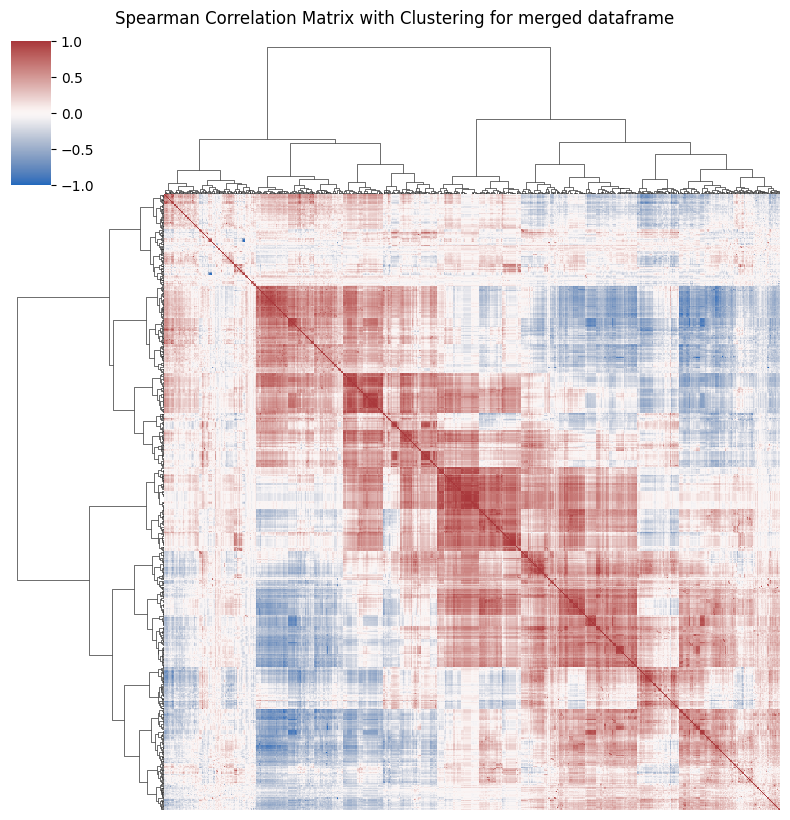

In [33]:
# plot correlation before analysis
corr_merged_df = merged_df.select_dtypes(["number"])
merged_corr = get_corr_matrix(category='merged', corr_df=corr_merged_df)
plot_correlation(corr=merged_corr, category='merged')


number of features original df for category merged: 757
shape clean corr table merged: (123, 123)


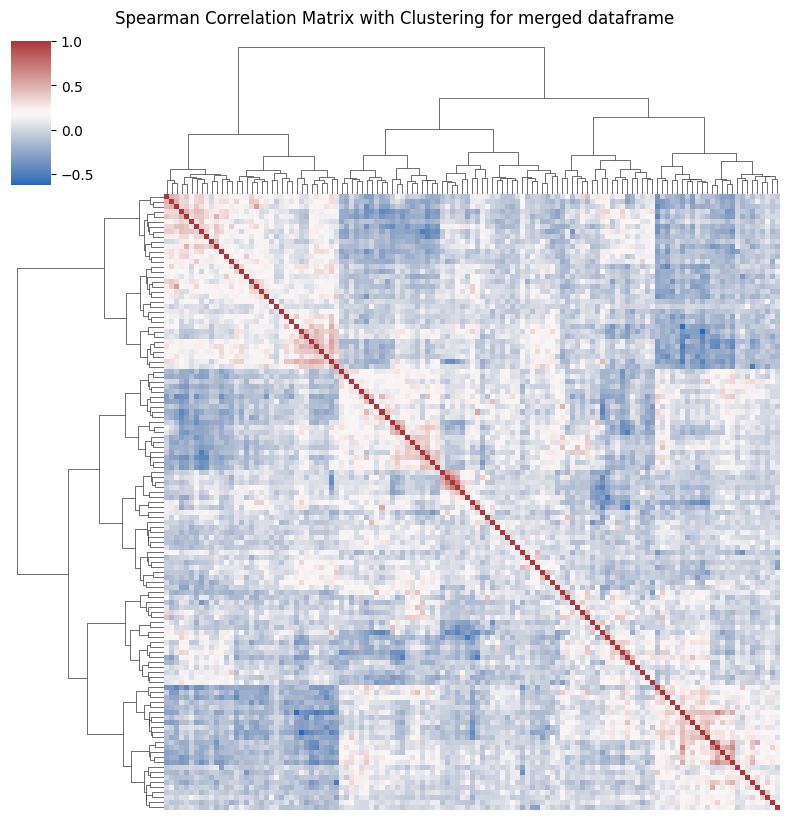

In [64]:
# run correlation pipeline on the large dataset:


similarity_analysis_df, dropped_columns = similarity_feature_selection_pipeline(
    category="merged", drop=True, describe=False, plot=True
)

In [35]:
similarity_analysis_df.to_csv('./data/processed_csv/02_merged_census_data.csv', index=False)

## EDA

Main features for visualization for each census metric category.

In [39]:
# prepare census columns dictionary by parameters that will be used for initial EDA
CENSUS_METRICS = {
    "education-attainment": {
        "HC02_EST_VC03": "Precent 18-24: Less than high school graduate",
        "HC04_EST_VC03": "Precent 18-24: Less than high school graduate - Men",
        "HC06_EST_VC03": "Precent 18-24: Less than high school graduate - Women",
        "HC02_EST_VC09": "Precent 25+: Less than 9th grade",
        "HC04_EST_VC09": "Precent 25+: Less than 9th grade - Men",
        "HC06_EST_VC09": "Precent 25+: Less than 9th grade - Women",
        "HC02_EST_VC17": "Percent high school graduate or higher",
        "HC04_EST_VC17": "Percent high school graduate or higher - Men",
        "HC06_EST_VC17": "Percent high school graduate or higher - Woman",
        "HC02_EST_VC42": "Percent; White - High school graduate or higher - White",
        "HC04_EST_VC42": "Percent; White - High school graduate or higher - White Men",
        "HC06_EST_VC42": "Percent; White - High school graduate or higher - White Women",
        "HC02_EST_VC46": "Percent; Black alone - High school graduate or higher",
        "HC02_EST_VC70": "Percent; Hispanic or Latino Origin - High school graduate or higher",
    },
    "education-attainment-over-25": {
        "HD01_VD01": "Total",
        "HD01_VD02": "No schooling completed",
        "HD01_VD17": "Total: Regular high school diploma",
        "HD01_VD23": "Total Master degree",
        "HD01_VD25": "Total Doctorate",
    },
    "employment": {
        "HC03_EST_VC01": "Employment/Population Ratio; 16 years and over",
        "HC04_EST_VC01": "Unemployment rate, 16 years and over",
    },
    "income": {
        "HC02_EST_VC02": "Households Median income $",
        "HC02_EST_VC04": "Households Median income $: White",
        "HC02_EST_VC05": "Households Median income $ Black of African American",
        "HC02_EST_VC07": "Households Median income $: Asian",
        "HC02_EST_VC12": "Households Median income $: Hispanic",
        "HC02_EST_VC26": "Households Median income $: Families no Father",
    },
    "owner-occupied-housing": {
        "HC02_EST_VC01": "Owner-occupied housing units",
        "HC03_EST_VC01": "Renter-occupied housing units",
    },
    "poverty": {
        "HC03_EST_VC01": "Percent below poverty level",
        "HC03_EST_VC03": "Percent below poverty level: Under 18",
        "HC03_EST_VC14": "Percent below poverty level: Men",
        "HC03_EST_VC15": "Percent below poverty level: Women",
        "HC03_EST_VC18": "Percent below poverty level: White",
        "HC03_EST_VC19": "Percent below poverty level: Black or African American",
        "HC03_EST_VC26": "ercent below poverty level: Hispanic",
    },
    "race-sex-age": {
        "HC03_VC23": "Median age (years)",
        "HC03_VC49": "Percent; White",
        "HC03_VC50": "Percent; Black or African American",
        "HC03_VC56": "Percent; Asian",
        "HC03_VC88": "Percent; Hispanic",
    },
}

In [ ]:
dropped_columns

In [40]:
# check that all the test columns were not dropped in the quality check, if yes, delete from census_metrics dict

for category, df in dpt_dfs.items():
    
    if category != 'merged':
        all_columns = df.columns

        # unpack the list of keys for each metric-category dict:
        metrics = [*CENSUS_METRICS[category]]
        metrics_to_drop = set(metrics).difference(set(all_columns))

        # collect all the columns that were dropped
        initial_assessment = all(item in all_columns for item in metrics)
        print(f"{category}: all columns exist: {initial_assessment}")

        # what was found:
        if not initial_assessment:
            print(f"\t {category}: metrics to drop: {[metrics_to_drop]}")
        for item in metrics_to_drop:
            print(f"deleting metrics: {CENSUS_METRICS[category].get(item)}")
            CENSUS_METRICS[category].pop(item)

education-attainment: all columns exist: True
education-attainment-over-25: all columns exist: True
employment: all columns exist: True
income: all columns exist: False
	 income: metrics to drop: [{'HC02_EST_VC26'}]
deleting metrics: Households Median income $: Families no Father
owner-occupied-housing: all columns exist: True
poverty: all columns exist: True
race-sex-age: all columns exist: False
	 race-sex-age: metrics to drop: [{'HC03_VC23'}]
deleting metrics: Median age (years)


In [41]:
# Verify missing values
for category, df in dpt_dfs.items():
    if category != 'merged':
        metrics = [*CENSUS_METRICS[category]]
        df = df[metrics]
        if not all(df.isna()):
            print(category)
            print(df.isna().sum())
        else:
            print(f"{category}: no missing values")

education-attainment: no missing values
education-attainment-over-25: no missing values
employment: no missing values
income: no missing values
owner-occupied-housing: no missing values
poverty: no missing values
race-sex-age: no missing values


## Census Tracts metrics visualisations

In [42]:
visualization_dfs = {}
for category, df in dpt_dfs.items():
    if category != 'merged':
        metrics = [*CENSUS_METRICS[category]]
        df = df[["GEO.id2"] + metrics]
        df.rename(columns={"GEO.id2": "GEOID"}, inplace=True)

        df.sort_values(by="GEOID", inplace=True)
        visualization_dfs[category] = df

### Population split 


Men and women are assumed to be split to 50/50.
Parameters:
```json
{"HC03_VC49": "Percent; White",
        "HC03_VC50": "Percent; Black or African American",
        "HC03_VC56": "Percent; Asian",
        "HC03_VC88": "Percent; Hispanic",
}
```

Index(['GEOID', 'HC03_VC49', 'HC03_VC50', 'HC03_VC56', 'HC03_VC88'], dtype='object')


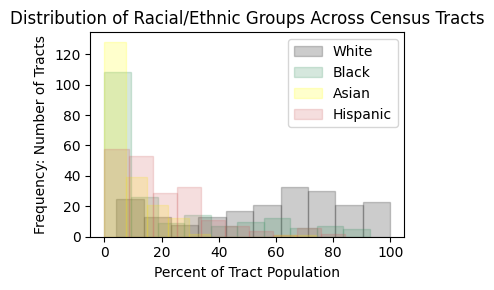

In [43]:
df = visualization_dfs["race-sex-age"].copy()
print(df.columns)

df.drop(columns=["GEOID"], inplace=True)
df.rename(
    columns={
        "HC03_VC49": "White",
        "HC03_VC50": "Black",
        "HC03_VC56": "Asian",
        "HC03_VC88": "Hispanic",
    },
    inplace=True,
)
colors = ["black", "seagreen", "yellow", "indianred"]
plt.figure(figsize=(4, 3))

for col, color in zip(df.columns, colors):
    plt.hist(df[col], bins=10, alpha=0.2, label=col, color=color, edgecolor=color)

plt.xlabel("Percent of Tract Population")
plt.ylabel("Frequency: Number of Tracts")
plt.title("Distribution of Racial/Ethnic Groups Across Census Tracts")
plt.legend()
plt.tight_layout()
plt.show()

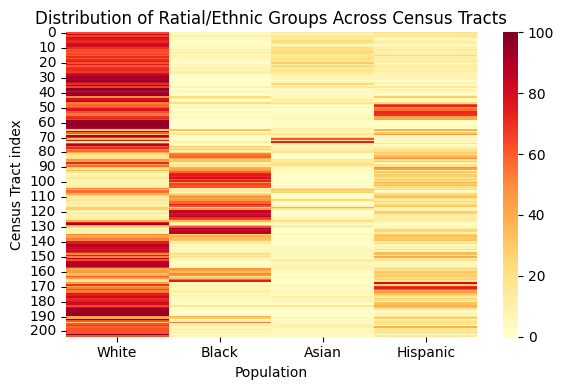

In [44]:
# with heatmap for better readability:

# Rows: Each row is a census tract (index can be tract ID or just 0–199)
plt.figure(figsize=(6, 4))
sns.heatmap(
    df.astype(float),
    cmap="YlOrRd",
)

plt.title("Distribution of Ratial/Ethnic Groups Across Census Tracts")
plt.xlabel("Population")
plt.ylabel("Census Tract index")
plt.tight_layout()
plt.show()

Interesting to see that the populations are very separated: the most concentrated majorities for each population are split in different city areas.

    - White pop: mostly majority in the tracts, mostly not a small minority
    - Black pop: minority in over a hundred tracts, to majority in up to 50 (out of around 200).
    - Asian pop: minority in most of the tracts, in single tracts majority. 
    - Hispanic pop: large minority in many tracts, in several tracts majority.

all these populations have majority in different areas, where the most of the majority areas, even if not a ruling majority, is white. 

### Employment

```json
"employment": {
        "HC03_EST_VC01": "Employment/Population Ratio; 16 years and over",
        "HC04_EST_VC01": "Unemployment rate, 16 years and over",
    },
    "income": {
        "HC02_EST_VC02": "Households Median income $",
        "HC02_EST_VC04": "Households Median income $: White",
        "HC02_EST_VC05": "Households Median income $ Black of African American",
        "HC02_EST_VC07": "Households Median income $: Asian",
        "HC02_EST_VC12": "Households Median income $: Hispanic",
        
    }
```

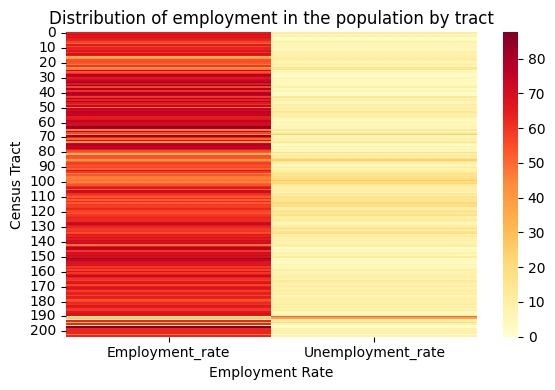

In [45]:
employment_df = visualization_dfs['employment'][['HC03_EST_VC01', 'HC04_EST_VC01']].copy()

employment_df.rename(
    columns={
        "HC03_EST_VC01": "Employment_rate",
        "HC04_EST_VC01": "Unemployment_rate",
    },
    inplace=True,
)

plt.figure(figsize=(6, 4))
sns.heatmap(
    employment_df.astype(float),
    cmap="YlOrRd",
)

plt.title("Distribution of employment in the population by tract")
plt.xlabel("Employment Rate")
plt.ylabel("Census Tract")
plt.tight_layout()
plt.show()

### Income

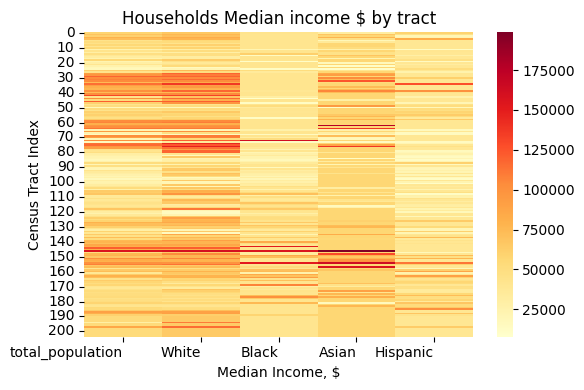

In [46]:
income_df = visualization_dfs['income'][['HC02_EST_VC02',	'HC02_EST_VC04',	'HC02_EST_VC05',	'HC02_EST_VC07',	'HC02_EST_VC12']].copy()
income_df.rename(
    columns= {"HC02_EST_VC02": "total_population",
        "HC02_EST_VC04": "White",
        "HC02_EST_VC05": "Black",
        "HC02_EST_VC07": "Asian",
        "HC02_EST_VC12": "Hispanic",
        },
inplace=True)

plt.figure(figsize=(6, 4))
sns.heatmap(
    income_df.astype(float),
    cmap="YlOrRd",
)

plt.title("Households Median income $ by tract")
plt.xlabel("Median Income, $")
plt.xticks(rotation=0, ha="right")
plt.ylabel("Census Tract Index")
plt.tight_layout()
plt.show()

### Poverty



```json
"poverty": {
        "HC03_EST_VC01": "Percent below poverty level",
        "HC03_EST_VC03": "Percent below poverty level: Under 18",
        "HC03_EST_VC14": "Percent below poverty level: Men",
        "HC03_EST_VC15": "Percent below poverty level: Women",
        "HC03_EST_VC18": "Percent below poverty level: White",
        "HC03_EST_VC19": "Percent below poverty level: Black or African American",
        "HC03_EST_VC26": "Hispanic",
    }

```

In [47]:
df = visualization_dfs["poverty"].copy()
df.rename(
    columns={
        "HC03_EST_VC01": "Total Population",
        "HC03_EST_VC03": "Under 18",
        "HC03_EST_VC14": "Men",
        "HC03_EST_VC15": "Women",
        "HC03_EST_VC18": "White",
        "HC03_EST_VC19": "Black",
        "HC03_EST_VC26": "Hispanic",
    },
    inplace=True,
)

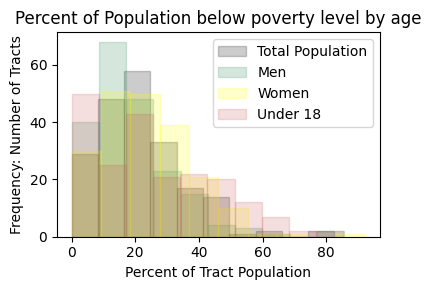

In [48]:
# Percent of Population below poverty level by age
columns = ["Total Population", "Men", "Women", "Under 18"]
colors = ["black", "seagreen", "yellow", "indianred"]
plt.figure(figsize=(4, 3))

for col, color in zip(columns, colors):
    plt.hist(df[col], bins=10, alpha=0.2, label=col, color=color, edgecolor=color)

plt.xlabel("Percent of Tract Population")
plt.ylabel("Frequency: Number of Tracts")
plt.title("Percent of Population below poverty level by age")
plt.legend()
plt.tight_layout()
plt.show()

under 25% of population live in poverty: in around half of the tracts, with sometimes many children under 18, larger than the percent of men or women, which might indicate families with many children. 
Under 18 how live in poverty: in between 60-80 tracts we can see a high percent of under 18 who live under the poverty line
In single tracts, there are poverty level of over 80%, mostly of men and women.


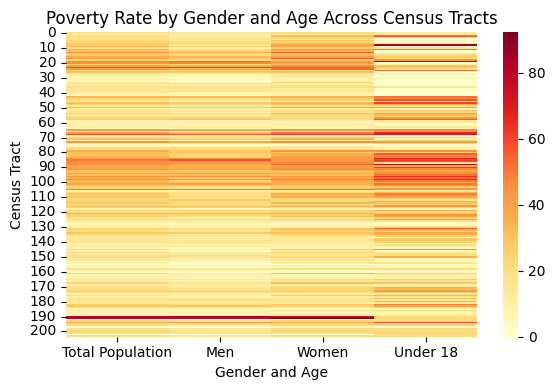

In [49]:
# with heatmap:

columns = ["Total Population", "Men", "Women", "Under 18"]
# Rows: Each row is a census tract (index can be tract ID or just 0–199)

plt.figure(figsize=(6, 4))
sns.heatmap(
    df[columns].astype(float),
    cmap="YlOrRd",
)

plt.title("Poverty Rate by Gender and Age Across Census Tracts")
plt.xlabel("Gender and Age")
plt.ylabel("Census Tract")
plt.tight_layout()
plt.show()

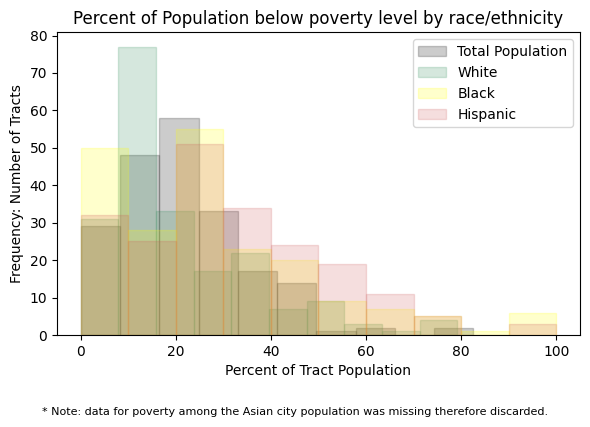

In [50]:
# Percent of Population below poverty level by race/ethnicity
columns = ["Total Population", "White", "Black", "Hispanic"]
colors = ["black", "seagreen", "yellow", "indianred"]
plt.figure(figsize=(6, 4))

for col, color in zip(columns, colors):
    plt.hist(df[col], bins=10, alpha=0.2, label=col, color=color, edgecolor=color)

plt.xlabel("Percent of Tract Population")
plt.ylabel("Frequency: Number of Tracts")
plt.title("Percent of Population below poverty level by race/ethnicity")
plt.legend()
plt.tight_layout()


# add a missing data comment
plt.subplots_adjust(bottom=0.15)
plt.figtext(
    0.5,
    -0.05,
    "* Note: data for poverty among the Asian city population was missing therefore discarded.",
    ha="center",
    fontsize=8,
    color="black",
)

plt.show()

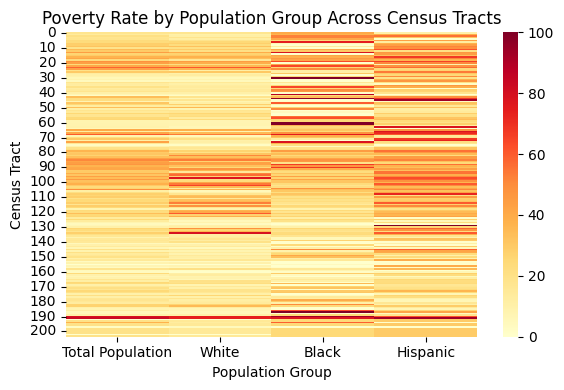

In [51]:
# with heatmap:

columns = ["Total Population", "White", "Black", "Hispanic"]
# Rows: Each row is a census tract (index can be tract ID or just 0–199)

plt.figure(figsize=(6, 4))
sns.heatmap(
    df[columns].astype(float),
    cmap="YlOrRd",
)

plt.title("Poverty Rate by Population Group Across Census Tracts")
plt.xlabel("Population Group")
plt.ylabel("Census Tract")
plt.tight_layout()
plt.show()

In tracts with the major parts of the populations under poverty level, Black an hispanic are the most affected populations. 
The percent of poverty of the total population, for these tracts, is lower. 
Nevertheless, several dosense tracts there is substancial percent of the black hispanic population that is living under the poverty level. 
White population: in many tracts (over 70)there is 10%-15% poverty in the white population. 
To conclude: most of the populations poverty concentrates in up to 40% poverty, in different curves of the distribution, where the Black and Hispanic populations have a longer tail to the right, towards higher poverty percentages. 

- there are some outliers above 100% for the Hispanic population, which we shall currently ignore. 

- the Area Census 190 is very poor across all all populations
- it seems from the map that the in the black population there is generally more percentage per census under the poverty limit
- It can be expected to see less crimes in census with the number 140-180 and 30-50
- in other areas we can see separation between the populations' poverty rate, where the leading is the black population, in the area of census 60, and the hispanic population are more correlated with the white population. 


### Education


```json
'education-attainment': {'HC02_EST_VC03': 'Precent 18-24: Less than high school graduate', 
                                'HC04_EST_VC03': 'Precent 18-24: Less than high school graduate - Men',
                                'HC06_EST_VC03': 'Precent 18-24: Less than high school graduate - Women',
                                'HC02_EST_VC09': 'Precent 25+: Less than 9th grade', 
                                'HC04_EST_VC09': 'Precent 25+: Less than 9th grade - Men', 
                                'HC06_EST_VC09': 'Precent 25+: Less than 9th grade - Women', 
                                'HC02_EST_VC17': 'Percent high school graduate or higher',
                                'HC04_EST_VC17': 'Percent high school graduate or higher - Men',
                                'HC06_EST_VC17': 'Percent high school graduate or higher - Woman',
                                'HC02_EST_VC42': 'Percent; White - High school graduate or higher - White', 
                                'HC04_EST_VC42': 'Percent; White - High school graduate or higher - White Men',
                                'HC06_EST_VC42': 'Percent; White - High school graduate or higher - White Women',
                                'HC02_EST_VC46': 'Percent; Black alone - High school graduate or higher',
                                'HC02_EST_VC70': 'Percent; Hispanic or Latino Origin - High school graduate or higher',
                                },
                 'education-attainment-over-25':  {'HD01_VD01': 'Total', 
                                                   'HD01_VD02':  'No schooling completed',
                                                   'HD01_VD17':'Total: Regular high school diploma',
                                                   'HD01_VD23': 'Total Master degree',
                                                   'HD01_VD25': 'Total Doctorate'},
```

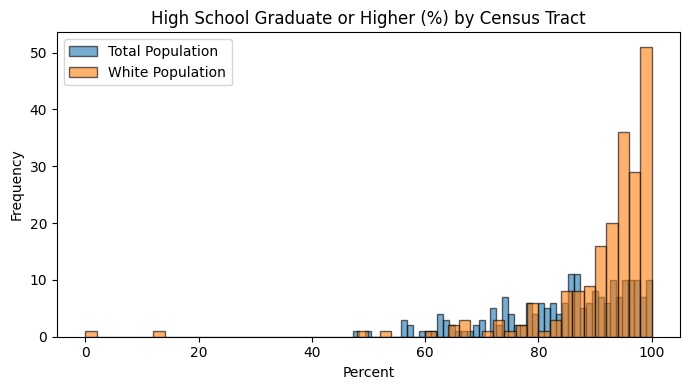

In [52]:
# high school graduate or higer total population and white population:

df = visualization_dfs["education-attainment"]
cols = ["HC02_EST_VC17", "HC02_EST_VC42"]
labels = ["Total Population", "White Population"]
plt.figure(figsize=(7, 4))
for col, label in zip(cols, labels):

    plt.hist(df[col], bins=50, alpha=0.6, edgecolor="black", label=label)

plt.title("High School Graduate or Higher (%) by Census Tract")
plt.xlabel("Percent")
plt.ylabel("Frequency")
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

There is a difference between the distributions of the total education and the white population education. add a split per race, to see where are the differences. 
it's also a bit weird that some of the values for the percent columns are over 100. 


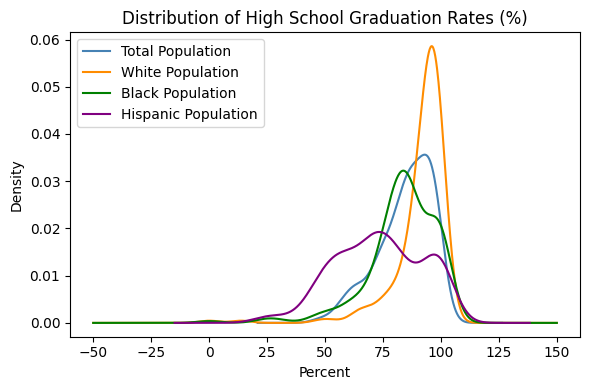

In [53]:
# plot for other populations:

cols = ["HC02_EST_VC17", "HC02_EST_VC42", "HC02_EST_VC46", "HC02_EST_VC70"]
labels = [
    "Total Population",
    "White Population",
    "Black Population",
    "Hispanic Population",
]
colors = ["steelblue", "darkorange", "green", "purple"]

plt.figure(figsize=(6, 4))

for col, label, color in zip(cols, labels, colors):
    df[col].plot.kde(label=label, color=color)

plt.title("Distribution of High School Graduation Rates (%)")
plt.xlabel("Percent")
plt.ylabel("Density")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Map visualisation: get to know the city

**mapping the census files:**
There GEO.id2 is the full Census Tract GEOID. we can see some distributions of the different demographic factors to understand the city
the GEOID can be downloaded from https://www.census.gov/cgi-bin/geo/shapefiles/index.php 
year chosen: 2020

In [54]:
CENSUS_SHAPE_PATH = os.path.join(DPT_ACS_PATH, "census_shapefiles")

In [55]:
tracts_gdf = gpd.read_file(os.path.join(CENSUS_SHAPE_PATH, "tl_2020_25_tract.shp"))
tracts_gdf.shape

(1620, 13)

In [56]:
# merge the shape file into the category dataframes
for category, df in visualization_dfs.items():
    print(category)
    df = visualization_dfs[category]

    merged_df = tracts_gdf.merge(df, on="GEOID")

    merged_df = merged_df.to_crs(epsg="4326")
    visualization_dfs[category] = merged_df
    
    print(merged_df.shape)

education-attainment
(180, 27)
education-attainment-over-25
(180, 18)
employment
(180, 15)
income
(180, 18)
owner-occupied-housing
(180, 15)
poverty
(180, 20)
race-sex-age
(180, 17)


(np.float64(-71.20346319999999),
 np.float64(-70.6216248),
 np.float64(42.21708675),
 np.float64(42.455220249999996))

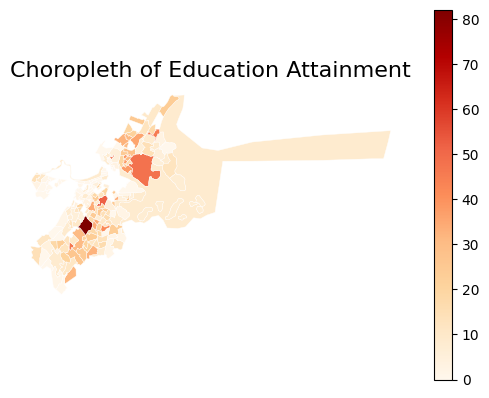

In [57]:
gdf = visualization_dfs['education-attainment'].copy()
fig, ax = plt.subplots()
# gdf.plot(ax=ax,color='#74b9ff',alpha=.4,edgecolor='white')

col = "HC02_EST_VC03"
gdf.plot(
    column=col,
    ax=ax,
    cmap="OrRd",  # Or 'plasma', 'viridis', 'coolwarm' etc.
    legend=True,
    edgecolor="white",
    linewidth=0.3,
    missing_kwds={"color": "lightgrey", "label": "Missing values"},
)

ax.set_title("Choropleth of Education Attainment", fontsize=16)
ax.axis("off")

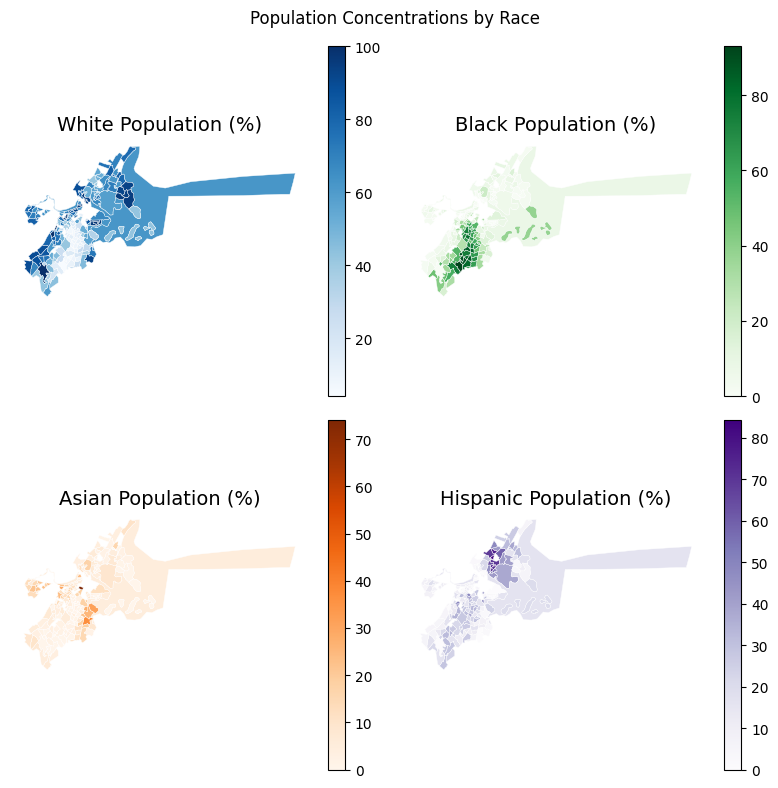

In [58]:
gdf = visualization_dfs["race-sex-age"].copy()

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle("Population Concentrations by Race")

pop_cols = {
    "HC03_VC49": "White Population (%)",
    "HC03_VC50": "Black Population (%)",
    "HC03_VC56": "Asian Population (%)",
    "HC03_VC88": "Hispanic Population (%)",
}

cmaps = ["Blues", "Greens", "Oranges", "Purples"]

for ax, (col, title), cmap in zip(axs.flatten(), pop_cols.items(), cmaps):
    gdf.plot(
        column=col,
        ax=ax,
        cmap=cmap,
        legend=True,
        edgecolor="white",
        linewidth=0.3,
        missing_kwds={"color": "lightgrey", "label": "Missing values"},
    )
    ax.set_title(title, fontsize=14)
    ax.axis("off")

plt.tight_layout()
plt.show()

 ```json
 "income": {
        "HC02_EST_VC02": "Households Median income $",
        "HC02_EST_VC04": "Households Median income $: White",
        "HC02_EST_VC05": "Households Median income $ Black of African American",
        "HC02_EST_VC07": "Households Median income $: Asian",
        "HC02_EST_VC12": "Households Median income $: Hispanic",
        "HC02_EST_VC26": "Households Median income $: Families no Father",
    },
    "owner-occupied-housing": {
        "HC02_EST_VC01": "Owner-occupied housing units",
        "HC03_EST_VC01": "Renter-occupied housing units",
    },
    "poverty": {
        "HC03_EST_VC01": "Percent below poverty level",
        "HC03_EST_VC03": "Percent below poverty level: Under 18",
        "HC03_EST_VC14": "Percent below poverty level: Men",
        "HC03_EST_VC15": "Percent below poverty level: Women",
        "HC03_EST_VC18": "Percent below poverty level: White",
        "HC03_EST_VC19": "Percent below poverty level: Black or African American",
        "HC03_EST_VC26": "ercent below poverty level: Hispanic",
    }
    ```

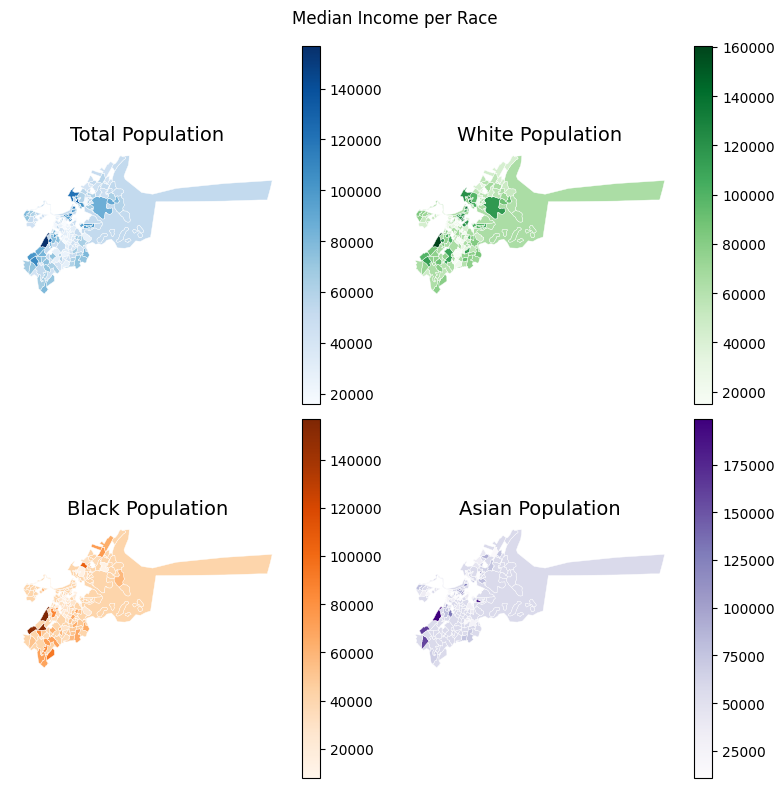

In [59]:
gdf = visualization_dfs["income"].copy()

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle("Median Income per Race")

cols = {
    "HC02_EST_VC02": "Total Population",
    "HC02_EST_VC04": "White Population",
    "HC02_EST_VC05": "Black Population",
    "HC02_EST_VC07": "Asian Population",
    "HC02_EST_VC12": "Hispanic Population",
}

cmaps = ["Blues", "Greens", "Oranges", "Purples"]

for ax, (col, title), cmap in zip(axs.flatten(), cols.items(), cmaps):
    gdf.plot(
        column=col,
        ax=ax,
        cmap=cmap,
        legend=True,
        edgecolor="white",
        linewidth=0.3,
        missing_kwds={"color": "lightgrey", "label": "Missing values"},
    )
    ax.set_title(title, fontsize=14)
    ax.axis("off")

plt.tight_layout()
plt.show()

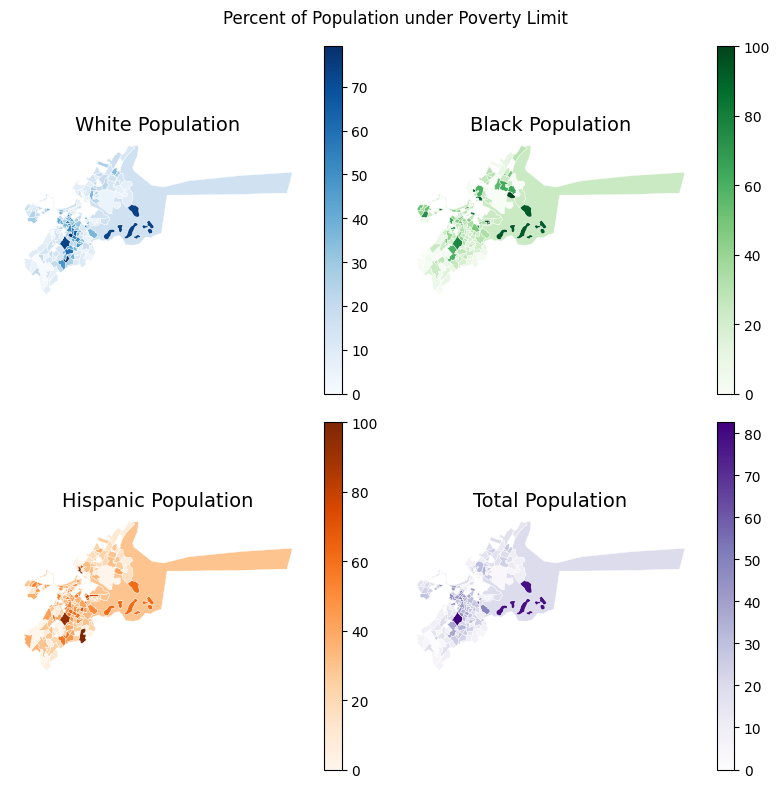

In [60]:
gdf = visualization_dfs["poverty"].copy()

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle("Percent of Population under Poverty Limit")


cols = {
    "HC03_EST_VC18": "White Population",
    "HC03_EST_VC19": "Black Population",
    "HC03_EST_VC26": "Hispanic Population",
    "HC03_EST_VC01": "Total Population",
}

cmaps = ["Blues", "Greens", "Oranges", "Purples"]

for ax, (col, title), cmap in zip(axs.flatten(), cols.items(), cmaps):
    gdf.plot(
        column=col,
        ax=ax,
        cmap=cmap,
        legend=True,
        edgecolor="white",
        linewidth=0.3,
        missing_kwds={"color": "lightgrey", "label": "Missing values"},
    )
    ax.set_title(title, fontsize=14)
    ax.axis("off")

plt.tight_layout()
plt.show()

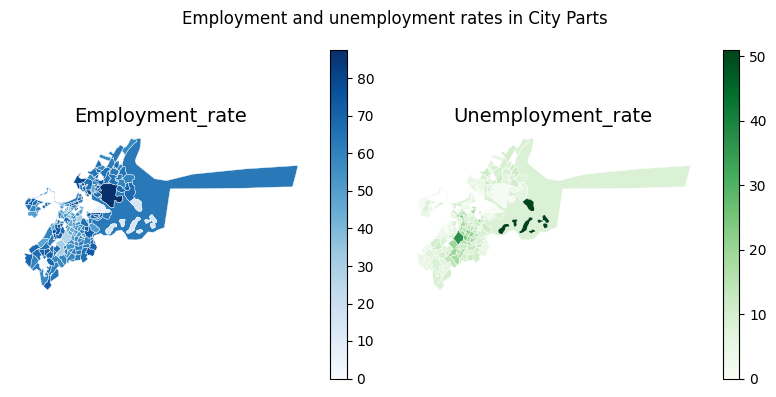

In [61]:
gdf = visualization_dfs['employment'].copy()

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("Employment and unemployment rates in City Parts")

cols = {
    "HC03_EST_VC01": "Employment_rate",
    "HC04_EST_VC01": "Unemployment_rate",
    }


cmaps = ["Blues", "Greens"]

for ax, (col, title), cmap in zip(axs.flatten(), cols.items(), cmaps):
    gdf.plot(
        column=col,
        ax=ax,
        cmap=cmap,
        legend=True,
        edgecolor="white",
        linewidth=0.3,
        missing_kwds={"color": "lightgrey", "label": "Missing values"},
    )
    ax.set_title(title, fontsize=14)
    ax.axis("off")

plt.tight_layout()
plt.show()